# Faster RADEM Simulation

In [65]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Constants

## PSD Constants

In [11]:
MATERIALS = {
    # Element: (Atomic mass, Atomic number, Density in g/cm^3)
    "Si": (28.0855, 14, 2.33),
    "Ta": (180.94788, 73, 16.65),
    "Al": (26.9815385, 13, 2.7),
    "Cu": (63.546, 29, 8.96),
    **{f"D{i}":(28.0855, 14, 2.33) for i in range(1, 9)}
}

PSD_LAYERS = (
    # (Material, Thickness in mm)
    ("Al", 0.2),
    ("D1", 0.3),
    ("D2", 0.3),
    ("Al", 0.4),
    ("D3", 0.3),
    ("Al", 1.2),
    ("D4", 0.3),
    ("Al", 3.3),
    ("D5", 0.3),
    ("Ta", 2.0),
    ("D6", 0.3),
    ("Ta", 4.8),
    ("D7", 0.3),
    ("Ta", 10.8),
    ("D8", 0.3),
)

PSD_RANGES = {
    "D1": (5, 8.2),
    "D2": (8.2, 13),
    "D3": (13, 22),
    "D4": (22, 35),
    "D5": (35, 58),
    "D6": (58, 94),
    "D7": (94, 153),
    "D8": (153, 250),
}

PSD_THRESHOLDS = {
    # channel,  LT [MeV], HT [MeV]
    "D1": (0.90972, 2.02692),
    "D2": (0.60648, 0.98724),
    "D3": (0.40356, 0.98724),
    "D4": (0.30324, 0.98724),
    "D5": (0.30324, 0.70680),
    "D6": (0.30324, 0.70680),
    "D7": (0.30324, 0.50616),
    "D8": (0.30324, 0.50616),
}

PSD_LOGIC = {
    1: {
        "D1": (None, True),
        "D2": (False, None),
        "D3": (None, None),
        "D4": (None, None),
        "D5": (None, None),
        "D6": (None, None),
        "D7": (None, None),
        "D8": (None, None),
    },
    2: {
        "D1": (True, None),
        "D2": (None, True),
        "D3": (False, None),
        "D4": (None, None),
        "D5": (None, None),
        "D6": (None, None),
        "D7": (None, None),
        "D8": (None, None),
    },
    3: {
        "D1": (True,None),
        "D2": (None,True),
        "D3": (None,True),
        "D4": (False,None),
        "D5": (None,None),
        "D6": (None,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    4: {
        "D1": (True,None),
        "D2": (None,True),
        "D3": (None,True),
        "D4": (None,True),
        "D5": (False,None),
        "D6": (None,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    5: {
        "D1": (None,None),
        "D2": (True,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (False,None),
        "D7": (None,None),
        "D8": (None,None),
    },
    6: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (False,None),
        "D8": (None,None),
    },
    7: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (True,None),
        "D8": (False,None),
    },
    8: {
        "D1": (None,None),
        "D2": (None,None),
        "D3": (True,None),
        "D4": (True,None),
        "D5": (True,None),
        "D6": (True,None),
        "D7": (True,None),
        "D8": (True,None),
    },
}

## Simulation

In [54]:
def _calc_bethe_bloch(beta, Zp, Zt, Mt, rho):
    # Constants
    c_light = 299792458             # [m/s]
    epsilon_0 = 8.854187817e-12;	# Coulomb / (V * m)
    me = 9.10938356e-31             # electron mass [kg]
    e = 1.6021766208e-19;		    # Elementary charge [Coulomb]
    m_amu = 1.660539040e-27;		# AMU [kg]
    m_amu_MeV = m_amu*c_light*c_light/e/1e6
    Na = 6.022140857e23     		# Avogadro constant

    # Rescale g/cm^-3 to cm^-3
    rho *= Na / Mt * 1e6

    beta2 = beta**2
    c2 = c_light**2
    n = Zt * rho
    I = 0
    if Zt < 13:
        I = 12 * Zt + 7
    else:
        I = 9.76 * Zt + 58.8 * math.exp(-0.19 * math.log(Zt))
    I *= e
    minusdEdx = 4 * math.pi * n * Zp * Zp / (me * c2 * beta2)
    minusdEdx *= math.pow(e * e / (4 * math.pi * epsilon_0), 2)
    minusdEdx *= (math.log(2 * me * c2 * beta2 / (I * (1 - beta2))) - beta2)
    minusdEdx *= 1 / e / 1000 / 1e6
    return minusdEdx

def _calc_stopping_range_in_material(Ep, Mp, Zp, Mt, Zt, rho):
    # Constants
    c_light = 299792458;		    # metres / sec
    e = 1.6021766208e-19;		    # Elementary charge [Coulomb]
    m_amu = 1.660539040e-27;		# AMU [kg]
    m_amu_MeV = m_amu*c_light*c_light/e/1e6
    Na = 6.022140857e23     		# Avogadro constant

    # Plot stuff
    plot_x = []
    plot_E = []
    plot_dEdx = []

    # Rescale g/cm^-3 to cm^-3
    rho_scaled = rho * Na / Mt * 1e6

    dx = 1e6 * 1e22 * Ep / rho_scaled / 1000 / Zt / Zp / Zp * Mp
    x = 0
    Eloss = 0
    lEloss = 0
    dElossdx = 0
    ldElossdx = 0
    sr = 0
    Ei = Ep
    while Ei > 0:
        gamma = (Ei + m_amu_MeV) / m_amu_MeV
        beta = math.pow(1 - 1 / (gamma * gamma), 0.5)
        Eloss = _calc_bethe_bloch(beta, Zp, Zt, Mt, rho) / Mp * dx
        if Eloss < 0:
            break
        
        Ei -= Eloss
        x += dx
        dElossdx = (Eloss - lEloss) / dx

        plot_dEdx.append(Eloss / dx)
        plot_E.append(Ei)
        plot_x.append(x)

        if sr == 0 and Ei <= 0.3 * Ep and dElossdx >= ldElossdx and dElossdx < 0:
            sr = x
        lEloss = Eloss
        ldElossdx = dElossdx
    if sr > 0:
        return sr, plot_x, plot_E, plot_dEdx
    else:
        return x, plot_x, plot_E, plot_dEdx

def plot_stopping_range(x, y, dEdx=None):
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    if dEdx is not None:
        plt.plot(x, dEdx)

    plt.title("Stopping Range")
    plt.xlabel("Depth [mm]")
    plt.ylabel("Energy [MeV]")
    plt.grid(True)
    plt.show()

def linear_interpolation(x_points, y_points, x_point):
    if len(x_points) != len(y_points):
        raise ValueError("The lists x_points and y_points must have the same length.")

    for i in range(len(x_points) - 1):
        if x_points[i] <= x_point <= x_points[i + 1]:
            return y_points[i] + (y_points[i + 1] - y_points[i]) * (x_point - x_points[i]) / (x_points[i + 1] - x_points[i])

    raise ValueError("x_point is outside the range of x_points.")

def find_closest_index(arr, value):
    return np.abs(arr - value).argmin()

def calc_proton_stopping_range_in_material_arr(E_max, material):
    _, x, y, _ = _calc_stopping_range_in_material(E_max, 1, 1, *material)
    return np.array((x, y)).T

def get_proton_deposited_e_in_material(proton_stopping_range_in_material_arr, material_thickness, E_in):
    index_in = find_closest_index(proton_stopping_range_in_material_arr[:, 1], E_in)    
    x_in = proton_stopping_range_in_material_arr[index_in, 0]
    
    index_out = find_closest_index(proton_stopping_range_in_material_arr[:, 0], x_in + material_thickness)
    
    E_deposited = proton_stopping_range_in_material_arr[index_in, 1] - proton_stopping_range_in_material_arr[index_out, 1]

    return E_deposited

def calc_proton_stopping_range_in_materials_dict(E_max):
    return {material: calc_proton_stopping_range_in_material_arr(E_max, MATERIALS[material]) for material in MATERIALS.keys()}

def apply_coincidence_logic(channels):
    result_bins = set()

    for bin_no, bin_logic in PSD_LOGIC.items():

        for channel, (using_lt, using_ht) in bin_logic.items():
            channel_lt, channel_ht = PSD_THRESHOLDS[channel]
            channel_value = channels[channel]

            if using_lt == True and channel_value < channel_lt:
                break
            elif using_lt == False and channel_value >= channel_lt:
                break
            elif using_ht == True and channel_value < channel_ht:
                break
            elif using_ht == False and channel_value >= channel_ht:
                break
        else:
            result_bins.add(bin_no)
    
    return result_bins

def simulate_psd(proton_stopping_range_in_materials_dict, init_energy):
    channels = {detector:0 for detector in PSD_RANGES.keys()}
    
    energy = init_energy

    for material, thickness in PSD_LAYERS:

        energy_diff = get_proton_deposited_e_in_material(proton_stopping_range_in_materials_dict[material], thickness, energy)
        energy -= energy_diff

        if material.startswith("D"):
            channels[material] = energy_diff

    return channels, apply_coincidence_logic(channels)

In [101]:
pstmd = calc_proton_stopping_range_in_materials_dict(250)

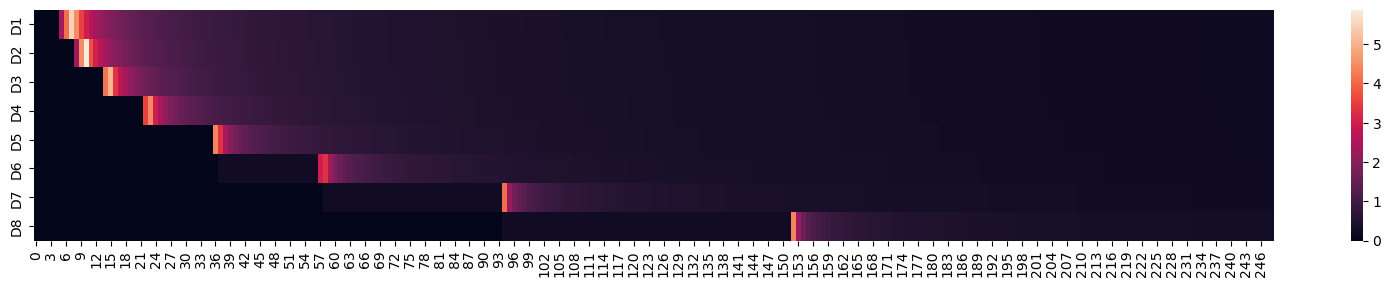

In [102]:
simulation_results = []
for i in range(1, 250):
    channels, _ = simulate_psd(pstmd, i)
    simulation_results.append(channels)
    
df_simulation_results = pd.DataFrame(simulation_results).T

# plot matrix of stopping ranges using seaborn
plt.figure(figsize=(20, 3))
sns.heatmap(df_simulation_results, annot=False)
plt.show()

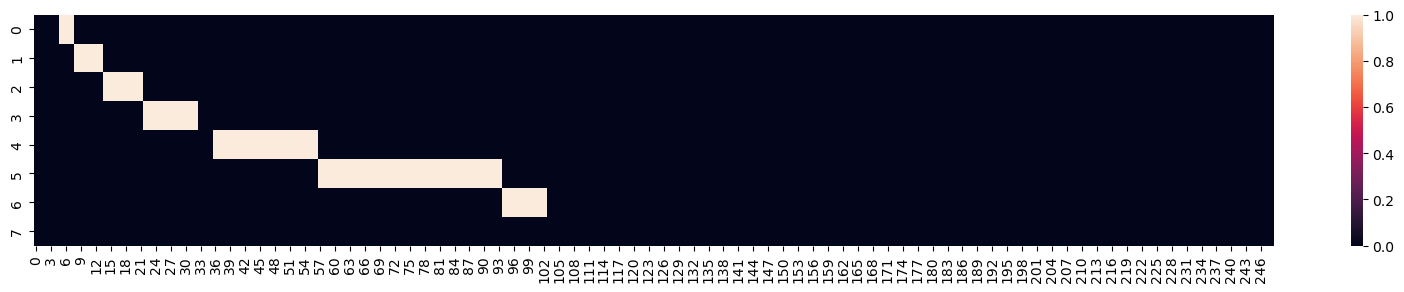

In [103]:
simulation_results = []
for i in range(1, 250):
    _, bins = simulate_psd(pstmd, i)
    simulation_results.append([bin_ in bins for bin_ in range(1, 9)])

df_simulation_results = pd.DataFrame(simulation_results).T

# plot matrix of stopping ranges using seaborn
plt.figure(figsize=(20, 3))
sns.heatmap(df_simulation_results, annot=False)
plt.show()